In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1149

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/1 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.755125	valid_0's recall_at4: 0.609148	valid_0's norm_gini: 0.901103
[100]	valid_0's amex_metric: 0.764148	valid_0's recall_at4: 0.621434	valid_0's norm_gini: 0.906862
[150]	valid_0's amex_metric: 0.770223	valid_0's recall_at4: 0.629976	valid_0's norm_gini: 0.910471
[200]	valid_0's amex_metric: 0.776629	valid_0's recall_at4: 0.639233	valid_0's norm_gini: 0.914025
[250]	valid_0's amex_metric: 0.780245	valid_0's recall_at4: 0.644029	valid_0's norm_gini: 0.91646
[300]	valid_0's amex_metric: 0.783944	valid_0's recall_at4: 0.649878	valid_0's norm_gini: 0.91801
[350]	valid_0's amex_metric: 0.785454	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.919221
[400]	valid_0's amex_metric: 0.787547	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.920209
[450]	valid_0's amex_metric: 0.789147	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.920885
[500]	valid_0's amex_metric: 0.790434	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.921439
[550]	valid_0'

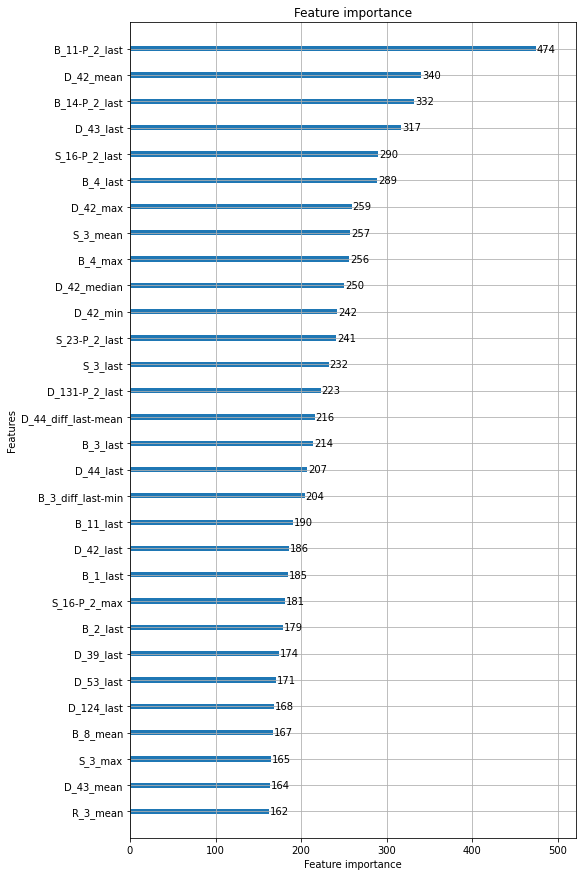

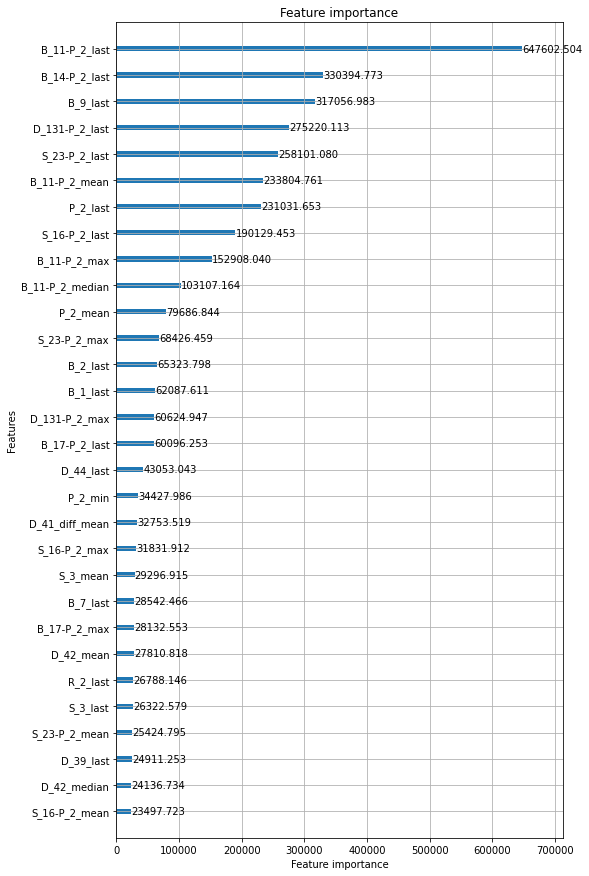

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.752178	valid_0's recall_at4: 0.604267	valid_0's norm_gini: 0.90009
[100]	valid_0's amex_metric: 0.761484	valid_0's recall_at4: 0.617353	valid_0's norm_gini: 0.905616
[150]	valid_0's amex_metric: 0.767633	valid_0's recall_at4: 0.62602	valid_0's norm_gini: 0.909245
[200]	valid_0's amex_metric: 0.773849	valid_0's recall_at4: 0.63473	valid_0's norm_gini: 0.912967
[250]	valid_0's amex_metric: 0.778703	valid_0's recall_at4: 0.642136	valid_0's norm_gini: 0.915271
[300]	valid_0's amex_metric: 0.781272	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.916915
[350]	valid_0's amex_metric: 0.784007	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.918093
[400]	valid_0's amex_metric: 0.78657	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.919096
[450]	valid_0's amex_metric: 0.787654	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.91975
[500]	valid_0's amex_metric: 0.787723	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.920308
[550]	valid_0's a

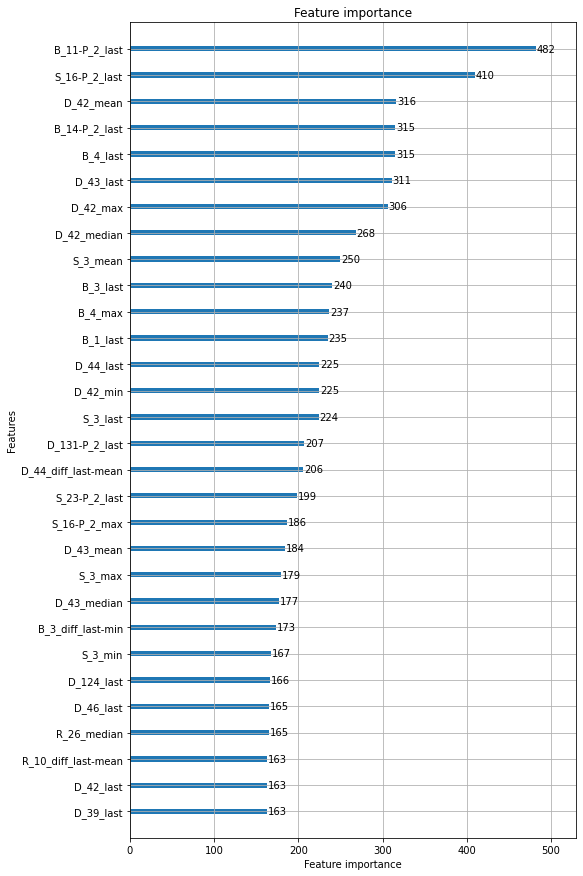

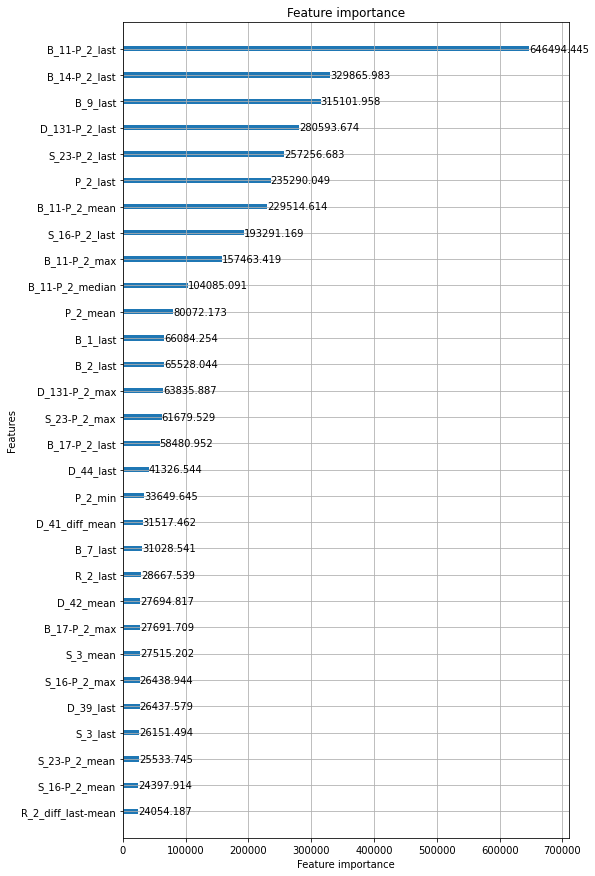

######################################## training model 3/5 ########################################
[50]	valid_0's amex_metric: 0.746682	valid_0's recall_at4: 0.594252	valid_0's norm_gini: 0.899112
[100]	valid_0's amex_metric: 0.756864	valid_0's recall_at4: 0.609021	valid_0's norm_gini: 0.904706
[150]	valid_0's amex_metric: 0.762882	valid_0's recall_at4: 0.617563	valid_0's norm_gini: 0.908202
[200]	valid_0's amex_metric: 0.76965	valid_0's recall_at4: 0.627451	valid_0's norm_gini: 0.911849
[250]	valid_0's amex_metric: 0.774093	valid_0's recall_at4: 0.634057	valid_0's norm_gini: 0.914129
[300]	valid_0's amex_metric: 0.776238	valid_0's recall_at4: 0.636834	valid_0's norm_gini: 0.915643
[350]	valid_0's amex_metric: 0.778496	valid_0's recall_at4: 0.640242	valid_0's norm_gini: 0.91675
[400]	valid_0's amex_metric: 0.780491	valid_0's recall_at4: 0.643272	valid_0's norm_gini: 0.91771
[450]	valid_0's amex_metric: 0.782028	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.918429
[500]	valid_

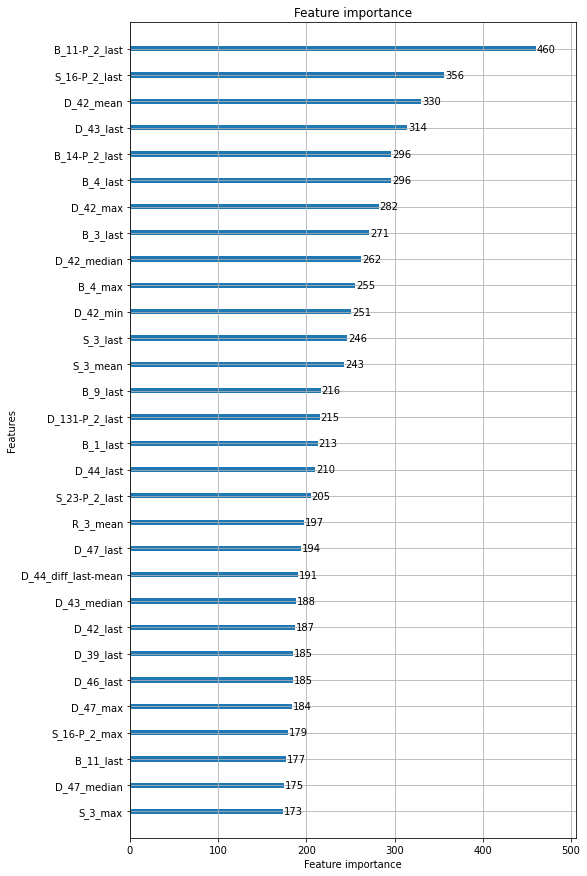

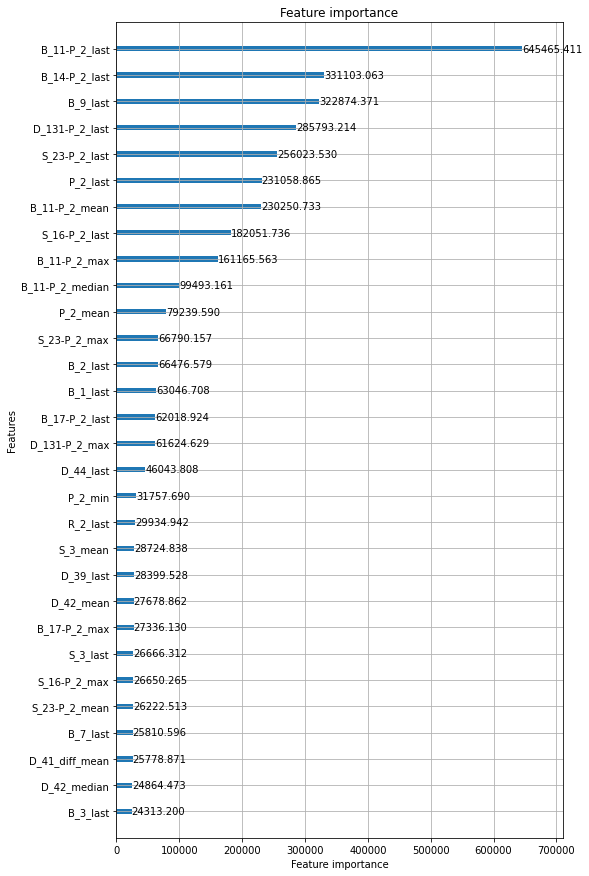

######################################## training model 4/5 ########################################
[50]	valid_0's amex_metric: 0.746618	valid_0's recall_at4: 0.59474	valid_0's norm_gini: 0.898495
[100]	valid_0's amex_metric: 0.7584	valid_0's recall_at4: 0.612413	valid_0's norm_gini: 0.904387
[150]	valid_0's amex_metric: 0.763339	valid_0's recall_at4: 0.618767	valid_0's norm_gini: 0.907911
[200]	valid_0's amex_metric: 0.769163	valid_0's recall_at4: 0.626762	valid_0's norm_gini: 0.911563
[250]	valid_0's amex_metric: 0.772355	valid_0's recall_at4: 0.630675	valid_0's norm_gini: 0.914035
[300]	valid_0's amex_metric: 0.775274	valid_0's recall_at4: 0.634883	valid_0's norm_gini: 0.915665
[350]	valid_0's amex_metric: 0.777659	valid_0's recall_at4: 0.638376	valid_0's norm_gini: 0.916942
[400]	valid_0's amex_metric: 0.779695	valid_0's recall_at4: 0.641405	valid_0's norm_gini: 0.917985
[450]	valid_0's amex_metric: 0.781237	valid_0's recall_at4: 0.643762	valid_0's norm_gini: 0.918713
[500]	valid_

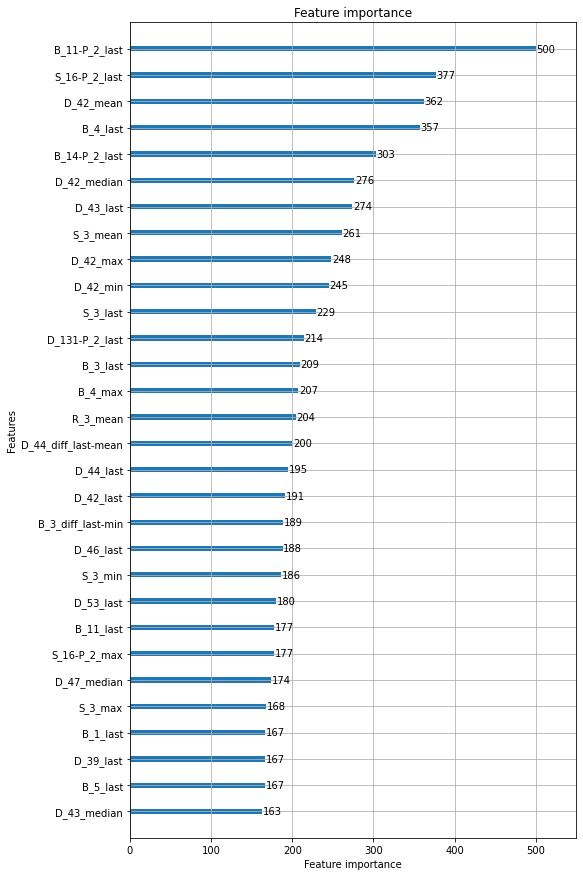

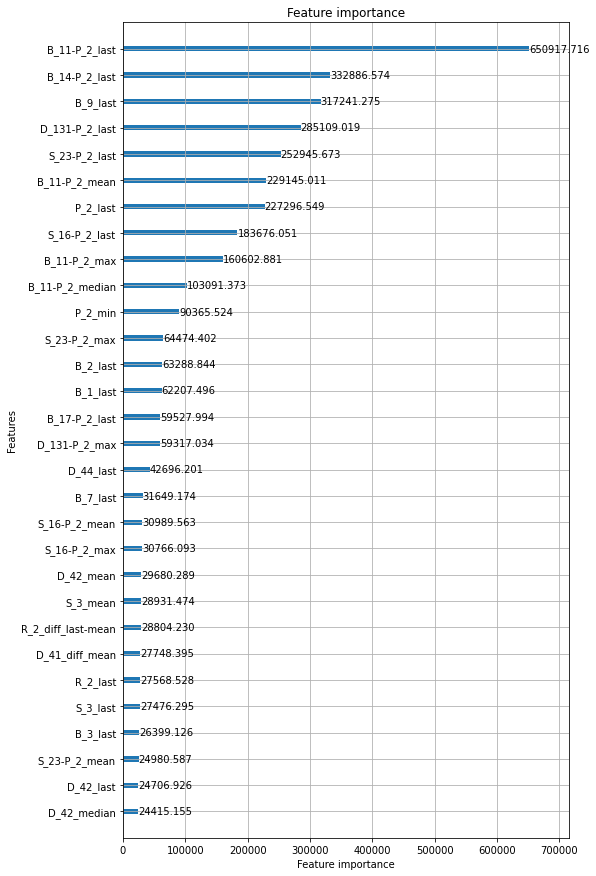

######################################## training model 5/5 ########################################
[50]	valid_0's amex_metric: 0.755385	valid_0's recall_at4: 0.608626	valid_0's norm_gini: 0.902144
[100]	valid_0's amex_metric: 0.766167	valid_0's recall_at4: 0.624237	valid_0's norm_gini: 0.908096
[150]	valid_0's amex_metric: 0.772244	valid_0's recall_at4: 0.632821	valid_0's norm_gini: 0.911667
[200]	valid_0's amex_metric: 0.777954	valid_0's recall_at4: 0.640564	valid_0's norm_gini: 0.915343
[250]	valid_0's amex_metric: 0.782395	valid_0's recall_at4: 0.64717	valid_0's norm_gini: 0.917621
[300]	valid_0's amex_metric: 0.784653	valid_0's recall_at4: 0.650074	valid_0's norm_gini: 0.919231
[350]	valid_0's amex_metric: 0.786745	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.920429
[400]	valid_0's amex_metric: 0.78876	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.921429
[450]	valid_0's amex_metric: 0.790308	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.922128
[500]	valid

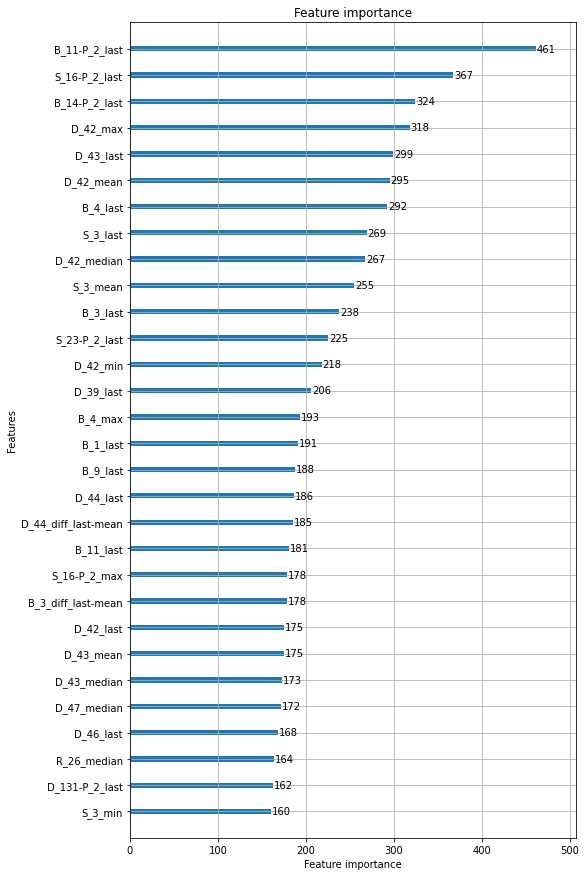

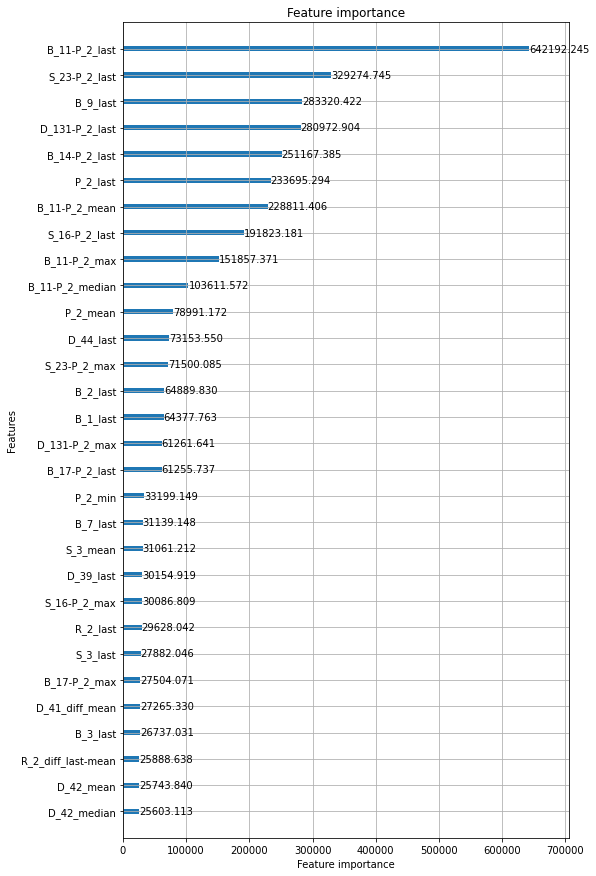

Training time: 34.23062517642975 min.
OOF recall_at4: 0.6676540882620258
OOF normalized_gini: 0.9253282130682312
OOF competition metric: 0.7964911506651284
CPU times: user 12h 14min 54s, sys: 43 s, total: 12h 15min 37s
Wall time: 34min 19s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.667654,0.925328,0.796491



mean:


recall_at4    0.667654
gini          0.925328
metric        0.796491
dtype: float64


std:


recall_at4   NaN
gini         NaN
metric       NaN
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 35min 31s, sys: 28 s, total: 35min 59s
Wall time: 2min 1s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.49 s, sys: 1.04 s, total: 4.53 s
Wall time: 4.68 s


***